In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import contextlib
import logging
import openbabel
from openbabel import pybel
import rdkit
import os
import sys

from random import randrange
from rdkit import Chem, RDLogger
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit.Chem import AllChem, rdMolAlign, Descriptors, Draw, rdFMCS
from rdkit.Chem.rdchem import Mol
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import rdFMCS, MolFromSmarts
from selfies import encoder, decoder 
from rdkit.Chem.Draw import MolToImage, IPythonConsole, rdMolDraw2D

import lomap

# Get the current working directory
current_dir = os.getcwd()

# Get the absolute path to the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to sys.path
sys.path.insert(0, parent_dir)

# Now you can import the module
from generator import fingerprint
from generator import generation
from generator import filters
from generator import scoring
from generator import visualization

import vis

In [7]:
liga_smiles = "O=C(Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1)c1ccccc1" #tyk2-43
ligb_smiles = "CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1" #tyk2-44
num_tries = 2
num_random_smiles = 2
num_random_samples = 2
collect_bidirectional = True
exponent_path = 1
n_rounds = 1
fp_type = "ECFP4"


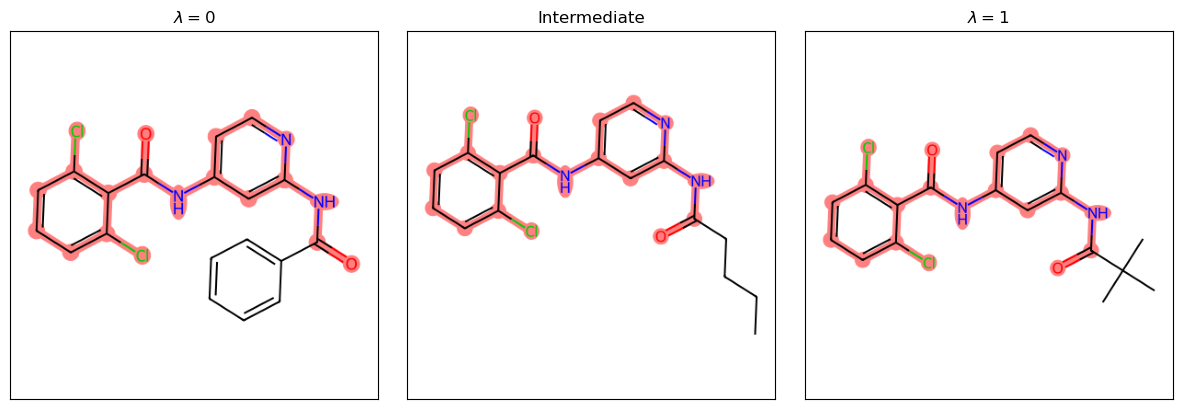

In [8]:
vis.visualise(liga_smiles, ligb_smiles, 'CCCCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')
#vis.visualise(liga_smiles, ligb_smiles, 'CC(C)CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')

R GROUP DECOMPOSITION AND CONNECTOR ATOM IDENTIFICATION

In [33]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.rdRGroupDecomposition import RGroupDecompose
from IPython.display import SVG

def find_mcs_smarts(mol_list):
    """
    Finds the MCS of a list of molecules and returns it as a SMARTS string.
    """
    mcs_result = rdFMCS.FindMCS(
        mol_list,
        atomCompare=rdFMCS.AtomCompare.CompareElements,
        bondCompare=rdFMCS.BondCompare.CompareAny,
        ringMatchesRingOnly=True,
        completeRingsOnly=True,
        timeout=10,
    )
    return mcs_result.smartsString

def remove_dummy_atoms(mol):
    """
    Removes dummy atoms (with atomic number 0) from a molecule and returns a new molecule.
    """
    editable_mol = Chem.EditableMol(mol)
    # Collect indices of dummy atoms to remove
    dummy_indices = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum() == 0]
    # Remove dummy atoms in reverse order to avoid indexing issues
    for idx in sorted(dummy_indices, reverse=True):
        editable_mol.RemoveAtom(idx)
    new_mol = editable_mol.GetMol()
    # Sanitize the molecule after modifications
    Chem.SanitizeMol(new_mol)
    return new_mol

def rgroup_decomposition(mol_list, core_smarts):
    """
    Performs R-group decomposition using the given core SMARTS.
    Returns a list of dictionaries, each containing R-groups for a molecule,
    both as Mol objects and as SMILES strings.
    """
    core = Chem.MolFromSmarts(core_smarts)
    rgroups_list, unmatched = RGroupDecompose([core], mol_list, asSmiles=False)

    # Generate SMILES strings for each R-group
    for rgroup_dict in rgroups_list:
        labels = list(rgroup_dict.keys())  # Make a list of the keys to avoid modifying the dict while iterating
        for label in labels:
            mol = rgroup_dict[label]
            if mol is not None and isinstance(mol, Chem.Mol):
                # SMILES including dummy atoms
                smiles_with_dummy = Chem.MolToSmiles(mol, isomericSmiles=True)
                rgroup_dict[label + '_smiles'] = smiles_with_dummy  # Store SMILES with dummy atoms
                # Remove dummy atoms to get SMILES without them
                mol_no_dummy = remove_dummy_atoms(mol)
                smiles_no_dummy = Chem.MolToSmiles(mol_no_dummy, isomericSmiles=True)
                rgroup_dict[label + '_smiles_no_dummy'] = smiles_no_dummy  # Store SMILES without dummy atoms
    return rgroups_list

def get_connector_atoms(rgroup):
    """
    Returns the indices of connector (dummy) atoms in the R-group molecule.
    """
    connector_atoms = []
    for atom in rgroup.GetAtoms():
        if atom.GetAtomicNum() == 0:  # Dummy atom
            connector_atoms.append(atom.GetIdx())
    return connector_atoms

def get_connector_atoms_in_mcs(core):
    """
    Returns the indices of attachment points (connector atoms) in the MCS.
    """
    attachment_points = []
    for atom in core.GetAtoms():
        if atom.GetAtomicNum() == 0:  # Dummy atom
            attachment_points.append(atom.GetIdx())
    return attachment_points

def visualize_molecule_with_highlight(mol, highlight_atoms, title="Molecule"):
    """
    Visualizes a molecule with specified atoms highlighted.
    """
    drawer = rdMolDraw2D.MolDraw2DSVG(400, 300)
    rdMolDraw2D.PrepareAndDrawMolecule(
        drawer,
        mol,
        highlightAtoms=highlight_atoms,
        highlightAtomColors={idx: (1.0, 0.0, 0.0) for idx in highlight_atoms},
        legend=title  # Pass the title as the legend
    )
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg))

def process_and_visualize(smiles_list):
    """
    Processes the molecules, performs R-group decomposition, and visualizes the MCS and R-groups.
    Returns the R-groups both as Mol objects and as SMILES strings.
    """
    mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

    # Find the MCS
    mcs_smarts = find_mcs_smarts(mol_list)
    mcs_mol = Chem.MolFromSmarts(mcs_smarts)
    print("MCS SMARTS:", mcs_smarts)

    # Perform R-group decomposition
    rgroups_list = rgroup_decomposition(mol_list, mcs_smarts)

    # Get connector atoms in MCS
    connector_atoms_mcs = get_connector_atoms_in_mcs(mcs_mol)

    # Visualize MCS with connector atoms highlighted
    print("Visualizing MCS with connector atoms highlighted:")
    visualize_molecule_with_highlight(mcs_mol, connector_atoms_mcs, title="MCS")

    # Process each molecule
    for idx, mol in enumerate(mol_list):
        # Get the R-groups for this molecule
        rgroup_dict = rgroups_list[idx]
        rgroup_mols = []
        rgroup_smiles = []
        for label in rgroup_dict.keys():
            if label.startswith("R") and not label.endswith("_smiles") and not label.endswith("_smiles_no_dummy"):
                rgroup = rgroup_dict[label]
                smiles_with_dummy = rgroup_dict.get(label + '_smiles', None)
                smiles_no_dummy = rgroup_dict.get(label + '_smiles_no_dummy', None)
                if rgroup is not None:
                    rgroup_mols.append((label, rgroup))
                    rgroup_smiles.append((label, smiles_with_dummy, smiles_no_dummy))

        # Visualize the original molecule
        print(f"Visualizing Molecule {idx+1}:")
        visualize_molecule_with_highlight(mol, [], title=f"Molecule {idx+1}")

        # Visualize each R-group with connector atoms highlighted
        for label, rgroup in rgroup_mols:
            connector_atoms = get_connector_atoms(rgroup)
            print(f"Visualizing {label} of Molecule {idx+1}:")
            visualize_molecule_with_highlight(rgroup, connector_atoms, title=f"{label} of Molecule {idx+1}")

        # Print R-group SMILES
        print(f"R-group SMILES for Molecule {idx+1}:")
        for label, smiles_with_dummy, smiles_no_dummy in rgroup_smiles:
            print(f"{label} with dummy atoms: {smiles_with_dummy}")
            print(f"{label} without dummy atoms: {smiles_no_dummy}")

    return rgroups_list


The following code is a try to add a dummy atom to the MCS, so we can use that later for attachment of generated R-groups

In [34]:
from rdkit import Chem
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display

def perform_rgroup_decomposition(mol_list):
    """
    Performs R-group decomposition and returns the core with attachment points and the R-groups.
    """
    # Initialize RGroupDecomposition with default parameters
    params = rdRGD.RGroupDecompositionParameters()
    params.removeHydrogens = False
    params.onlyMatchAtRGroups = True

    # Perform R-group decomposition
    rgd = rdRGD.RGroupDecomposition(None, params)
    for mol in mol_list:
        rgd.Add(mol)
    rgd.Process()

    # Get the core with attachment points
    cores = rgd.GetCores()

    # Get the R-groups
    rgroup_rows = rgd.GetRGroupsAsRows(asSmiles=False)

    return cores, rgroup_rows


MCS SMARTS: [#6&!R](=&!@[#8&!R])-&!@[#7&!R]-&!@[#6]1:&@[#6]:&@[#6](-&!@[#7&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6]2:&@[#6](-&!@[#17&!R]):&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@2-&!@[#17&!R]):&@[#6]:&@[#6]:&@[#7]:&@1
Visualizing MCS with connector atoms highlighted:


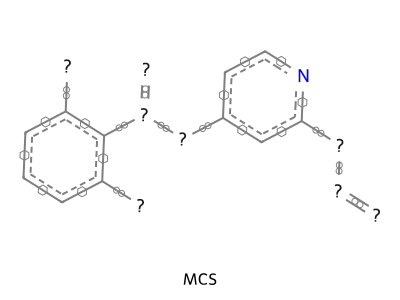

Visualizing Molecule 1:


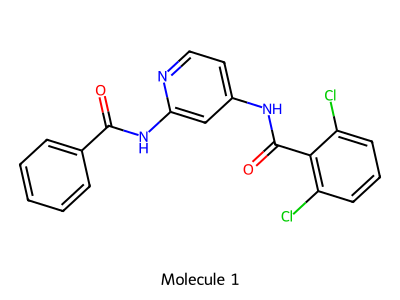

Visualizing R1 of Molecule 1:


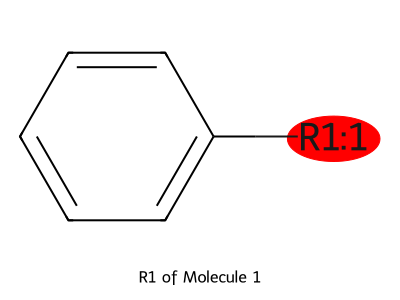

R-group SMILES for Molecule 1:
R1 with dummy atoms: c1ccc([*:1])cc1
R1 without dummy atoms: c1ccccc1
Visualizing Molecule 2:


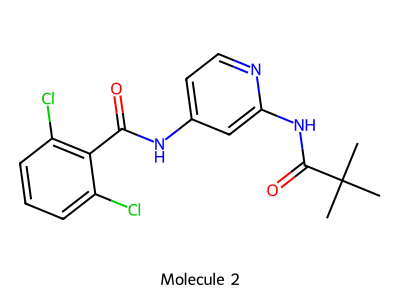

Visualizing R1 of Molecule 2:


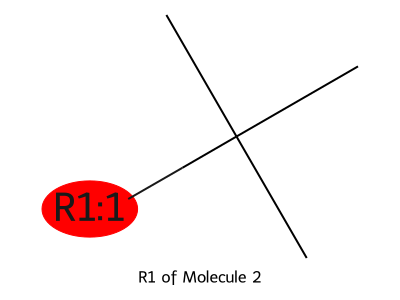

R-group SMILES for Molecule 2:
R1 with dummy atoms: CC(C)(C)[*:1]
R1 without dummy atoms: CC(C)C


In [35]:
# Example usage with your SMILES strings
smiles_1 = "O=C(Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1)c1ccccc1"  # tyk2-43
smiles_2 = "CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1"  # tyk2-44

# Process molecules and get R-groups
rgroups = process_and_visualize([smiles_1, smiles_2])

In [36]:
# Accessing R-groups for the first molecule
first_molecule_rgroups = rgroups[1]
for label in first_molecule_rgroups:
    if label.startswith('R') and not label.endswith('_smiles') and not label.endswith('_smiles_no_dummy'):
        rgroup_mol = first_molecule_rgroups[label]
        smiles_with_dummy = first_molecule_rgroups.get(label + '_smiles')
        smiles_no_dummy = first_molecule_rgroups.get(label + '_smiles_no_dummy')
        print(f"{label} Mol object:", rgroup_mol)
        print(f"{label} SMILES with dummy atoms:", smiles_with_dummy)
        print(f"{label} SMILES without dummy atoms:", smiles_no_dummy)

R1 Mol object: <rdkit.Chem.rdchem.Mol object at 0x7f01953daf10>
R1 SMILES with dummy atoms: CC(C)(C)[*:1]
R1 SMILES without dummy atoms: CC(C)C


In [37]:
# Extract R1 without dummy atoms for both molecules
rgroup_smiles_list = []

for i, first_molecule_rgroups in enumerate(rgroups):
    if 'R1_smiles_no_dummy' in first_molecule_rgroups:
        smiles_no_dummy_r1 = first_molecule_rgroups['R1_smiles_no_dummy']
        rgroup_smiles_list.append(smiles_no_dummy_r1)
        print(f"Molecule {i+1} R1 without dummy atoms: {smiles_no_dummy_r1}")
    else:
        print(f"Molecule {i+1} does not have an R1 group without dummy atoms.")


print(rgroup_smiles_list)
liga_smiles_rgroup = rgroup_smiles_list[0]
ligb_smiles_rgroup = rgroup_smiles_list[1]


Molecule 1 R1 without dummy atoms: c1ccccc1
Molecule 2 R1 without dummy atoms: CC(C)C
['c1ccccc1', 'CC(C)C']


With the R-groups of the parent molecules ready, we can do generation of intermediate R-groups.

In [38]:
num_tries = 10
num_random_samples = 10


intermediate_rgroups = generation.get_compr_paths(liga_smiles_rgroup, ligb_smiles_rgroup, num_tries, num_random_samples, collect_bidirectional, fp_type)


In [39]:
def flatten_list(input_data):
    """
    Recursively flattens a list of lists into a single list.
    
    Args:
    input_data (list): A list that may contain nested lists.

    Returns:
    list: A single flattened list.
    """
    flat_list = []
    for item in input_data:
        if isinstance(item, list):
            flat_list.extend(flatten_list(item))  # Recursively flatten the list
        else:
            flat_list.append(item)
    return flat_list

def get_unique_r_groups_from_quoted_strings(input_data):
    """
    Extracts unique values from a potentially nested list structure.
    
    Args:
    input_data (list): A list of lists containing strings.
    
    Returns:
    list: A list of unique values.
    """
    # Flatten the input data
    flat_list = flatten_list(input_data)

    # Convert to a set to remove duplicates, then back to a list
    unique_r_groups = list(set(flat_list))

    return unique_r_groups

In [40]:
unique_rgroups = get_unique_r_groups_from_quoted_strings(intermediate_rgroups)
print(unique_rgroups)
print(len(unique_rgroups))

['CCC=CC=C', 'C1CC=C1', 'C=CCC', 'C=CCCC=C', 'C1CCCC=C1', 'C=CC#C', 'C=C(C)C', 'CCC=C', 'C=CC=CC=C', 'C=CC=CC#C', 'C1C(C)=C1', 'C1C(C)C1', 'C=CC=C', 'C=C(C1)C1', 'C1=CC=CC=C1', 'C1CC=CC=C1', 'CC(C)=C', 'CCCCC#C', 'CC(C1)=C1', 'C1=C(C)C1', 'C1=CC=C1', 'CCCCC=C', 'CC(C)C', 'C1=CC=CCC1', 'C1=CCCCC1', 'CC(C1)C1', 'CCC=CC#C', 'CCC=CCC', 'CCCC', 'C1CCC1', 'C=CCCC#C', 'C1=CCCC=C1', 'C=CCCCC', 'C1=CCC1', 'CCCCCC', 'C=CC=CCC', 'C1CC=CCC1']
37


Following code has a limitation:
get_dummy_adjacent_atom_idx assumes there is only one dummy atom in the original R-group (issue with macrocycles that get split, or multiple connections otherwise)

In [41]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display

def get_dummy_adjacent_atom_idx(original_rgroup):
    """
    Finds the index of the atom in the original R-group that is adjacent to the dummy atom.

    Args:
        original_rgroup (Chem.Mol): Original R-group molecule with dummy atom.

    Returns:
        int: Atom index adjacent to the dummy atom.
    """
    dummy_idx = None
    for atom in original_rgroup.GetAtoms():
        if atom.GetAtomicNum() == 0:
            dummy_idx = atom.GetIdx()
            break

    if dummy_idx is None:
        return None

    # Get neighbors of the dummy atom
    dummy_atom = original_rgroup.GetAtomWithIdx(dummy_idx)
    neighbors = dummy_atom.GetNeighbors()
    if not neighbors:
        return None

    # Return the index of the atom adjacent to the dummy atom
    adjacent_atom_idx = neighbors[0].GetIdx()
    return adjacent_atom_idx

def tag_generated_rgroup_with_dummy(generated_rgroup_smiles, original_rgroups):
    """
    Tags the appropriate atom in the generated R-group with a dummy atom
    based on the MCS with the original R-groups.

    Args:
        generated_rgroup_smiles (str): SMILES string of the generated R-group.
        original_rgroups (list of Chem.Mol): List of original R-group molecules with dummy atoms.

    Returns:
        Chem.Mol: Modified generated R-group molecule with a dummy atom.
    """
    generated_rgroup = Chem.MolFromSmiles(generated_rgroup_smiles)
    if generated_rgroup is None:
        print(f"Invalid generated R-group SMILES: {generated_rgroup_smiles}")
        return None

    for original_rgroup in original_rgroups:
        # Compute the MCS between the generated R-group and the original R-group
        mcs_result = rdFMCS.FindMCS([generated_rgroup, original_rgroup],
                                    atomCompare=rdFMCS.AtomCompare.CompareElements,
                                    bondCompare=rdFMCS.BondCompare.CompareAny,
                                    ringMatchesRingOnly=True,
                                    completeRingsOnly=True,
                                    timeout=10)

        if not mcs_result.canceled:
            mcs_smarts = mcs_result.smartsString
            mcs_mol = Chem.MolFromSmarts(mcs_smarts)

            if mcs_mol is None or mcs_mol.GetNumAtoms() == 0:
                continue

            # Get mappings from MCS to both molecules
            match_generated = generated_rgroup.GetSubstructMatch(mcs_mol)
            match_original = original_rgroup.GetSubstructMatch(mcs_mol)

            if not match_generated or not match_original:
                continue

            # Get the index of the atom adjacent to the dummy atom in the original R-group
            original_adjacent_idx = get_dummy_adjacent_atom_idx(original_rgroup)
            if original_adjacent_idx is None:
                continue

            # Find the corresponding atom in the generated R-group via MCS mapping
            # Find the index in the MCS that maps to the adjacent atom in the original R-group
            mcs_adjacent_idx = None
            for idx, orig_idx in enumerate(match_original):
                if orig_idx == original_adjacent_idx:
                    mcs_adjacent_idx = idx
                    break

            if mcs_adjacent_idx is None:
                continue

            # Now find the corresponding atom in the generated R-group
            generated_adjacent_idx = match_generated[mcs_adjacent_idx]

            # Tag this atom in the generated R-group with a dummy atom
            editable_rgroup = Chem.RWMol(generated_rgroup)
            # Replace the atom with a dummy atom
            editable_rgroup.ReplaceAtom(generated_adjacent_idx, Chem.Atom(0))
            modified_rgroup = editable_rgroup.GetMol()
            Chem.SanitizeMol(modified_rgroup)
            return modified_rgroup

    # If no suitable attachment point is found, return None or handle accordingly
    print(f"No suitable attachment point found for R-group: {generated_rgroup_smiles}")
    return None

def combine_core_and_rgroup(core_mol, modified_rgroup):
    """
    Combines the core molecule with a modified R-group molecule at the dummy atoms.

    Args:
        core_mol (Chem.Mol): RDKit molecule of the core (MCS).
        modified_rgroup (Chem.Mol): Modified generated R-group molecule with dummy atom.

    Returns:
        Chem.Mol: Combined molecule.
    """
    # Find the dummy atoms (atomic number 0)
    core_dummy_idx = None
    rgroup_dummy_idx = None

    for atom in core_mol.GetAtoms():
        if atom.GetAtomicNum() == 0:
            core_dummy_idx = atom.GetIdx()
            break

    for atom in modified_rgroup.GetAtoms():
        if atom.GetAtomicNum() == 0:
            rgroup_dummy_idx = atom.GetIdx()
            break

    if core_dummy_idx is None or rgroup_dummy_idx is None:
        print("No dummy atom found in core or modified R-group.")
        return None

    # Combine the molecules
    combined = Chem.RWMol(Chem.CombineMols(core_mol, modified_rgroup))

    # Adjust atom indices (atoms from rgroup_mol are after core_mol's atoms)
    rgroup_atom_offset = core_mol.GetNumAtoms()

    # Remove dummy atoms and create a bond
    combined.RemoveAtom(rgroup_dummy_idx + rgroup_atom_offset)
    combined.RemoveAtom(core_dummy_idx)
    combined.AddBond(core_dummy_idx, rgroup_dummy_idx + rgroup_atom_offset - 1, order=Chem.rdchem.BondType.SINGLE)

    # Sanitize the molecule
    Chem.SanitizeMol(combined)

    return combined.GetMol()

def visualize_molecule(mol, title='Molecule'):
    """
    Visualizes a molecule.

    Args:
        mol (Chem.Mol): RDKit molecule.
        title (str): Title for the molecule.
    """
    drawer = rdMolDraw2D.MolDraw2DSVG(400, 300)
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, legend=title)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg))




In [43]:
def add_dummy_atom_to_generated_rgroup(gen_rgroup_smiles, orig_rgroups):
    """
    Adds a dummy atom to the generated R-group at the position corresponding to the attachment point.
    """
    gen_rgroup = Chem.MolFromSmiles(gen_rgroup_smiles)
    if gen_rgroup is None:
        print(f"Invalid SMILES: {gen_rgroup_smiles}")
        return None

    # Compare with each original R-group
    for orig_rgroup in orig_rgroups:
        # Find MCS between generated and original R-groups
        mcs_result = rdFMCS.FindMCS([gen_rgroup, orig_rgroup],
                                    atomCompare=rdFMCS.AtomCompare.CompareElements,
                                    bondCompare=rdFMCS.BondCompare.CompareAny,
                                    ringMatchesRingOnly=True,
                                    completeRingsOnly=True,
                                    timeout=10)
        if mcs_result.canceled or mcs_result.numAtoms == 0:
            continue

        mcs = Chem.MolFromSmarts(mcs_result.smartsString)
        if mcs is None:
            continue

        # Map MCS to generated R-group
        gen_match = gen_rgroup.GetSubstructMatch(mcs)
        orig_match = orig_rgroup.GetSubstructMatch(mcs)

        if not gen_match or not orig_match:
            continue

        # Identify the attachment point in the original R-group
        orig_dummy_idx = None
        for atom in orig_rgroup.GetAtoms():
            if atom.GetAtomicNum() == 0:
                orig_dummy_idx = atom.GetIdx()
                break

        if orig_dummy_idx is None:
            continue

        # Find the atom in the original R-group connected to the dummy atom
        orig_dummy_atom = orig_rgroup.GetAtomWithIdx(orig_dummy_idx)
        neighbors = orig_dummy_atom.GetNeighbors()
        if not neighbors:
            continue
        orig_adjacent_idx = neighbors[0].GetIdx()

        # Find the corresponding atom in the MCS
        mcs_attachment_idx = None
        for i, idx in enumerate(orig_match):
            if idx == orig_adjacent_idx:
                mcs_attachment_idx = i
                break

        if mcs_attachment_idx is None:
            continue

        # Map to the generated R-group
        gen_attachment_idx = gen_match[mcs_attachment_idx]

        # Replace the atom in the generated R-group with a dummy atom
        editable_gen_rgroup = Chem.RWMol(gen_rgroup)
        editable_gen_rgroup.ReplaceAtom(gen_attachment_idx, Chem.Atom(0))
        modified_gen_rgroup = editable_gen_rgroup.GetMol()
        Chem.SanitizeMol(modified_gen_rgroup)
        return modified_gen_rgroup

    # If no matching attachment point is found, return None
    return None


In [44]:
def combine_core_and_rgroup(core, rgroup):
    """
    Combines the core molecule with the R-group at the dummy atoms.
    """
    # Find dummy atoms in core and rgroup
    core_dummy_idx = None
    for atom in core.GetAtoms():
        if atom.GetAtomicNum() == 0:
            core_dummy_idx = atom.GetIdx()
            break

    rgroup_dummy_idx = None
    for atom in rgroup.GetAtoms():
        if atom.GetAtomicNum() == 0:
            rgroup_dummy_idx = atom.GetIdx()
            break

    if core_dummy_idx is None or rgroup_dummy_idx is None:
        print("No dummy atom found in core or R-group.")
        return None

    # Combine molecules
    combined = Chem.RWMol(Chem.CombineMols(core, rgroup))
    rgroup_offset = core.GetNumAtoms()

    # Remove dummy atoms and create bond
    combined.RemoveAtom(rgroup_dummy_idx + rgroup_offset)
    combined.RemoveAtom(core_dummy_idx)
    combined.AddBond(core_dummy_idx, rgroup_dummy_idx + rgroup_offset - 1, order=Chem.rdchem.BondType.SINGLE)

    Chem.SanitizeMol(combined)
    return combined.GetMol()


In [45]:
# Get original R-groups with dummy atoms
original_rgroups = []
for rgroup_row in rgroup_rows:
    rgroup = rgroup_row.get('R1', None)
    if rgroup:
        original_rgroups.append(rgroup)

# List of generated R-group SMILES (without dummy atoms)
generated_rgroups_smiles = ['CCC=CC=C', 'C1CC=C1', 'C=CCC', 'C=CCCC=C', 'C1CCCC=C1', 'C=CC#C', 'C=C(C)C', 'CCC=C',
                            'C=CC=CC=C', 'C=CC=CC#C', 'C1C(C)C1', 'C=CC=C', 'C=C(C1)C1', 'C1=CC=CC=C1', 'C1CC=CC=C1',
                            'CC(C)=C', 'CCCCC#C', 'CC(C1)=C1', 'C1=C(C)C1', 'CCC#C', 'C1=CC=C1', 'CCCCC=C', 'CC(C)C',
                            'C1=CC=CCC1', 'C1=CCCCC1', 'CC(C1)C1', 'CCC=CC#C', 'CCC=CCC', 'CCCC', 'C1CCC1', 'C=CCCC#C',
                            'C1=CCCC=C1', 'C1CCCCC1', 'C1=CCC1', 'C=CCCCC', 'CCCCCC', 'C=CC=CCC', 'C1CC=CCC1']

# Process each generated R-group
for idx, gen_rgroup_smiles in enumerate(generated_rgroups_smiles):
    # Add dummy atom to generated R-group
    modified_rgroup = add_dummy_atom_to_generated_rgroup(gen_rgroup_smiles, original_rgroups)
    if modified_rgroup is None:
        print(f"Skipping R-group {gen_rgroup_smiles} due to missing attachment point.")
        continue

    # Combine core and modified R-group
    new_molecule = combine_core_and_rgroup(core, modified_rgroup)
    if new_molecule:
        print(f"Generated Molecule {idx+1}:")
        visualize_molecule(new_molecule, title=f"Generated Molecule {idx+1}")
        new_smiles = Chem.MolToSmiles(new_molecule)
        print(f"SMILES: {new_smiles}")
    else:
        print(f"Failed to generate molecule for R-group {gen_rgroup_smiles}")


NameError: name 'rgroup_rows' is not defined

In [42]:
# Prepare the original R-groups (with dummy atoms)
# Assuming you have the original R-groups from your earlier code
# For illustration, let's use the R1 groups from your two molecules
original_rgroup_smiles_list = [
    rgroups[0]['R1_smiles'],  # R1 of Molecule 1 with dummy atoms
    rgroups[1]['R1_smiles']   # R1 of Molecule 2 with dummy atoms
]

original_rgroups = [Chem.MolFromSmiles(smi) for smi in original_rgroup_smiles_list]

# Prepare the core molecule (MCS)
# Assuming the MCS is the core molecule with a dummy atom

# this must have been returned before, optimize by not running calculation again
mola = Chem.MolFromSmiles(liga_smiles)
molb = Chem.MolFromSmiles(ligb_smiles)

mcs_smarts = find_mcs_smarts([mola, molb])
core_mol = Chem.MolFromSmarts(mcs_smarts)

# For demonstration, let's assume the core molecule has a dummy atom at the correct position
# If not, we need to modify the core molecule to include a dummy atom at the attachment point

# List of generated R-group SMILES (without dummy atoms)
generated_rgroups = ['CCC=CC=C', 'C1CC=C1', 'C=CCC', 'C=CCCC=C', 'C1CCCC=C1', 'C=CC#C', 'C=C(C)C', 'CCC=C',
                     'C=CC=CC=C', 'C=CC=CC#C', 'C1C(C)C1', 'C=CC=C', 'C=C(C1)C1', 'C1=CC=CC=C1', 'C1CC=CC=C1',
                     'CC(C)=C', 'CCCCC#C', 'CC(C1)=C1', 'C1=C(C)C1', 'CCC#C', 'C1=CC=C1', 'CCCCC=C', 'CC(C)C',
                     'C1=CC=CCC1', 'C1=CCCCC1', 'CC(C1)C1', 'CCC=CC#C', 'CCC=CCC', 'CCCC', 'C1CCC1', 'C=CCCC#C',
                     'C1=CCCC=C1', 'C1CCCCC1', 'C1=CCC1', 'C=CCCCC', 'CCCCCC', 'C=CC=CCC', 'C1CC=CCC1']

# Process each generated R-group
for idx, gen_rgroup_smiles in enumerate(generated_rgroups):
    # Tag the appropriate atom in the generated R-group with a dummy atom
    modified_rgroup = tag_generated_rgroup_with_dummy(gen_rgroup_smiles, original_rgroups)
    if modified_rgroup is None:
        continue  # Skip this R-group if no attachment point was found

    # Combine the core and the modified R-group
    combined_mol = combine_core_and_rgroup(core_mol, modified_rgroup)
    if combined_mol:
        print(f"Generated Molecule {idx+1}:")
        visualize_molecule(combined_mol, title=f"Molecule {idx+1}")
        # You can also save or process the molecule further
        # For example, get the SMILES string:
        combined_smiles = Chem.MolToSmiles(combined_mol)
        print(f"SMILES: {combined_smiles}")
    else:
        print(f"Failed to generate molecule for R-group SMILES: {gen_rgroup_smiles}")

No dummy atom found in core or modified R-group.
Failed to generate molecule for R-group SMILES: CCC=CC=C
No suitable attachment point found for R-group: C1CC=C1
No dummy atom found in core or modified R-group.
Failed to generate molecule for R-group SMILES: C=CCC
No dummy atom found in core or modified R-group.
Failed to generate molecule for R-group SMILES: C=CCCC=C
No dummy atom found in core or modified R-group.
Failed to generate molecule for R-group SMILES: C1CCCC=C1
No dummy atom found in core or modified R-group.
Failed to generate molecule for R-group SMILES: C=CC#C
No dummy atom found in core or modified R-group.
Failed to generate molecule for R-group SMILES: C=C(C)C
No dummy atom found in core or modified R-group.
Failed to generate molecule for R-group SMILES: CCC=C
No dummy atom found in core or modified R-group.
Failed to generate molecule for R-group SMILES: C=CC=CC=C
No dummy atom found in core or modified R-group.
Failed to generate molecule for R-group SMILES: C=CC=C

In [46]:
# [Include all the previous functions and code here]

# Updated processing loop with default attachment point fallback
for idx, gen_rgroup_smiles in enumerate(generated_rgroups_smiles):
    # Add dummy atom to generated R-group
    modified_rgroup = add_dummy_atom_to_generated_rgroup(gen_rgroup_smiles, original_rgroups)
    if modified_rgroup is None:
        # Use default attachment point
        modified_rgroup = add_dummy_atom_to_generated_rgroup_default(gen_rgroup_smiles, attachment='start')
        if modified_rgroup is None:
            print(f"Skipping R-group {gen_rgroup_smiles} due to invalid structure.")
            continue

    # Combine core and modified R-group
    new_molecule = combine_core_and_rgroup(core, modified_rgroup)
    if new_molecule:
        print(f"Generated Molecule {idx+1}:")
        visualize_molecule(new_molecule, title=f"Generated Molecule {idx+1}")
        new_smiles = Chem.MolToSmiles(new_molecule)
        print(f"SMILES: {new_smiles}")
    else:
        print(f"Failed to generate molecule for R-group {gen_rgroup_smiles}")


NameError: name 'generated_rgroups_smiles' is not defined